In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']
import seaborn as sns
import itertools
from tqdm import tqdm
import joblib

In [2]:
d0 = np.array([1.])

In [3]:
πs = [
    np.array([[1., 0.],]),
    np.array([[0., 1.],]),
    np.array([[0.5, 0.5],]),
    np.array([[0.1, 0.9],]),
    np.array([[0.8, 0.2],]),
]

In [4]:
use_πD = False

In [250]:
N = 1

In [251]:
def single_run(runs = 1000, annot_std_scale=1.0):
    np.random.seed(42)

    # True value of π_e
    Js = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_e[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        J = np.sum(r) / N
        Js.append(J)

    # Standard IS
    Gs = []
    OISs = []
    WISs = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        G = np.sum(r) / N
        Gs.append(G)

        if use_πD:
            π_b_ = np.array([
                [(np.sum((x==0)&(a==0)))/np.sum(x==0), 
                 (np.sum((x==0)&(a==1)))/np.sum(x==0)],
            ])
        else:
            π_b_ = π_b

        rho = π_e[x,a] / π_b_[x,a]
        OISs.append(np.sum(rho * r) / N)
        WISs.append(np.sum(rho * r) / np.sum(rho))


    # Collect data using π_b - combining counterfactuals with factuals
    FC_OISs_w = []
    FC_WISs_w = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        rng_c = np.random.default_rng(seed=100000+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        rho = π_e[x,a] / π_b[x,a]

        # counterfactual flag
        c = np.array([rng_c.choice(2, p=[1-Pc[xi,ai], Pc[xi,ai]]) for xi,ai in zip(x,a)])

        # counterfactual reward
        rc = np.array([rng_c.normal(R[xi,1-ai], annot_std_scale*sigma[xi,1-ai]) for xi,ai in zip(x,a)])
        rc[c==0] = np.nan

        # trajectory-wise weight
        w = np.ones(N)
        w[c==1] = ww[x[c==1], a[c==1], a[c==1]]
        wc = np.zeros(N)
        wc[c==1] = ww[x[c==1], a[c==1], 1-a[c==1]]

        if use_πD:
            # augmented behavior policy
            π_b_ = np.array([
                [(np.sum(w*((x==0)&(a==0)))+np.sum(wc*((x==0)&(a==1)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1)))), 
                 (np.sum(w*((x==0)&(a==1)))+np.sum(wc*((x==0)&(a==0)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1))))],
            ])
        else:
            # augmented behavior policy
            π_b_ = np.array([
                [π_b[0,0]*ww[0,0,0]+π_b[0,1]*ww[0,1,0], π_b[0,0]*ww[0,0,1]+π_b[0,1]*ww[0,1,1]],
            ])
            π_b_ = π_b_ / π_b_.sum(axis=1, keepdims=True)

        FC_OISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (N)
        )
        FC_WISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (np.sum(w* π_e[x,a] / π_b_[x,a]) + np.sum((wc* π_e[x,1-a] / π_b_[x,1-a])[c==1])),
        )

    df_bias_var = []
    for name, values in [
        ('$\hat{v}(\pi_e)$', Js),
        ('$\hat{v}(\pi_b)$', Gs),
        ('OIS', OISs),
        ('WIS', WISs),
        ('C-OIS', FC_OISs_w),
        ('C-WIS', FC_WISs_w),
    ]:
        df_bias_var.append([name, 
                            np.mean(values), 
                            np.mean(values - d0@np.sum(π_e*R, axis=1)), 
                            np.sqrt(np.var(values)), 
                            np.sqrt(np.mean(np.square(values - d0@np.sum(π_e*R, axis=1))))])
    return pd.DataFrame(df_bias_var, columns=['Approach', 'Mean', 'Bias', 'Std', 'RMSE'])

# Ideal counterfactual annotations, sweep weights

In [7]:
## probability of getting a counterfactual annotation
Pc = np.array([
    [1., 1.],
])

In [8]:
w_list = list(np.arange(0,1.+1e-10,0.1).round(2))

In [9]:
w_list

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

## >>Same variance

In [389]:
R, sigma = np.array([[1, 2.],]), np.array([[1., 1.],])

In [390]:
π_b = πs[3]
π_e = πs[4]
print(π_b, π_e)

[[0.1 0.9]] [[0.8 0.2]]


In [391]:
df_out_sweepW_3a = []
for wwww, www_ in itertools.product(w_list, w_list):
    ww = np.array([[
        [wwww, 1-wwww],
        [1-www_, www_],
    ]])
    df_out = single_run()
    df_out_sweepW_3a.append(df_out)

<ipython-input-251-568fab191dfe>:77: RuntimeWarning: invalid value encountered in true_divide
  (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (N)
<ipython-input-251-568fab191dfe>:80: RuntimeWarning: invalid value encountered in true_divide
  (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (np.sum(w* π_e[x,a] / π_b_[x,a]) + np.sum((wc* π_e[x,1-a] / π_b_[x,1-a])[c==1])),


In [392]:
df_tmp = pd.DataFrame(index=w_list, columns=w_list)
df_tmp.index.name = 'wwww'
for (i, wwww), (j, www_) in itertools.product(enumerate(w_list), enumerate(w_list)):
    ix = i*len(w_list) + j
    df_tmp.iloc[i, j] = str(df_out_sweepW_3a[ix].iloc[[2,4], [2,3,4]].round(2).values)[1:-1]
display(df_tmp.style.set_properties(**{'white-space': 'pre-wrap'}))

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
wwww,,,,,,,,,,,
0.0,[0.09 3.37 3.37] [0.06 1.41 1.41],[0.09 3.37 3.37] [0.04 0.92 0.92],[0.09 3.37 3.37] [0.04 0.84 0.84],[0.09 3.37 3.37] [0.03 0.83 0.83],[0.09 3.37 3.37] [0.03 0.83 0.83],[0.09 3.37 3.37] [0.03 0.84 0.84],[0.09 3.37 3.37] [0.03 0.85 0.85],[0.09 3.37 3.37] [0.03 0.85 0.85],[0.09 3.37 3.37] [0.03 0.86 0.86],[0.09 3.37 3.37] [0.03 0.87 0.87],[0.09 3.37 3.37] [ nan nan nan]
0.1,[0.09 3.37 3.37] [0.06 1.43 1.43],[0.09 3.37 3.37] [0.04 0.91 0.91],[0.09 3.37 3.37] [0.04 0.83 0.83],[0.09 3.37 3.37] [0.03 0.82 0.82],[0.09 3.37 3.37] [0.03 0.82 0.82],[0.09 3.37 3.37] [0.03 0.82 0.82],[0.09 3.37 3.37] [0.03 0.82 0.82],[0.09 3.37 3.37] [0.03 0.81 0.81],[0.09 3.37 3.37] [0.03 0.8 0.8 ],[0.09 3.37 3.37] [0.04 0.78 0.78],[0.09 3.37 3.37] [0.09 3.47 3.47]
0.2,[0.09 3.37 3.37] [0.06 1.45 1.45],[0.09 3.37 3.37] [0.04 0.89 0.9 ],[0.09 3.37 3.37] [0.04 0.82 0.82],[0.09 3.37 3.37] [0.04 0.81 0.81],[0.09 3.37 3.37] [0.03 0.8 0.8 ],[0.09 3.37 3.37] [0.03 0.8 0.8 ],[0.09 3.37 3.37] [0.03 0.8 0.8 ],[0.09 3.37 3.37] [0.03 0.79 0.79],[0.09 3.37 3.37] [0.04 0.78 0.78],[0.09 3.37 3.37] [0.04 0.84 0.84],[0.09 3.37 3.37] [0.09 3.46 3.46]
0.3,[0.09 3.37 3.37] [0.06 1.47 1.47],[0.09 3.37 3.37] [0.04 0.88 0.88],[0.09 3.37 3.37] [0.04 0.81 0.81],[0.09 3.37 3.37] [0.04 0.8 0.8 ],[0.09 3.37 3.37] [0.03 0.79 0.8 ],[0.09 3.37 3.37] [0.03 0.79 0.79],[0.09 3.37 3.37] [0.03 0.79 0.79],[0.09 3.37 3.37] [0.04 0.78 0.78],[0.09 3.37 3.37] [0.04 0.8 0.8 ],[0.09 3.37 3.37] [0.04 0.95 0.95],[0.09 3.37 3.37] [0.09 3.45 3.45]
0.4,[0.09 3.37 3.37] [0.06 1.49 1.49],[0.09 3.37 3.37] [0.04 0.86 0.86],[0.09 3.37 3.37] [0.04 0.8 0.8 ],[0.09 3.37 3.37] [0.04 0.79 0.79],[0.09 3.37 3.37] [0.03 0.79 0.79],[0.09 3.37 3.37] [0.03 0.79 0.79],[0.09 3.37 3.37] [0.04 0.78 0.78],[0.09 3.37 3.37] [0.04 0.79 0.79],[0.09 3.37 3.37] [0.04 0.83 0.83],[0.09 3.37 3.37] [0.05 1.08 1.08],[0.09 3.37 3.37] [0.09 3.44 3.44]
0.5,[0.09 3.37 3.37] [0.06 1.5 1.51],[0.09 3.37 3.37] [0.04 0.84 0.84],[0.09 3.37 3.37] [0.04 0.79 0.8 ],[0.09 3.37 3.37] [0.04 0.79 0.79],[0.09 3.37 3.37] [0.04 0.78 0.79],[0.09 3.37 3.37] [0.04 0.78 0.78],[0.09 3.37 3.37] [0.04 0.79 0.79],[0.09 3.37 3.37] [0.04 0.8 0.81],[0.09 3.37 3.37] [0.04 0.88 0.88],[0.09 3.37 3.37] [0.05 1.21 1.21],[0.09 3.37 3.37] [0.09 3.43 3.43]
0.6,[0.09 3.37 3.37] [0.06 1.52 1.53],[0.09 3.37 3.37] [0.04 0.82 0.83],[0.09 3.37 3.37] [0.04 0.79 0.79],[0.09 3.37 3.37] [0.04 0.78 0.78],[0.09 3.37 3.37] [0.04 0.78 0.78],[0.09 3.37 3.37] [0.04 0.78 0.79],[0.09 3.37 3.37] [0.04 0.79 0.79],[0.09 3.37 3.37] [0.04 0.83 0.83],[0.09 3.37 3.37] [0.04 0.94 0.94],[0.09 3.37 3.37] [0.05 1.33 1.33],[0.09 3.37 3.37] [0.09 3.41 3.42]
0.7,[0.09 3.37 3.37] [0.06 1.54 1.55],[0.09 3.37 3.37] [0.04 0.81 0.81],[0.09 3.37 3.37] [0.04 0.78 0.79],[0.09 3.37 3.37] [0.04 0.78 0.78],[0.09 3.37 3.37] [0.04 0.78 0.78],[0.09 3.37 3.37] [0.04 0.79 0.79],[0.09 3.37 3.37] [0.04 0.81 0.81],[0.09 3.37 3.37] [0.04 0.85 0.86],[0.09 3.37 3.37] [0.04 1. 1. ],[0.09 3.37 3.37] [0.05 1.43 1.43],[0.09 3.37 3.37] [0.09 3.4 3.41]
0.8,[0.09 3.37 3.37] [0.06 1.56 1.57],[0.09 3.37 3.37] [0.04 0.79 0.79],[0.09 3.37 3.37] [0.04 0.78 0.78],[0.09 3.37 3.37] [0.04 0.78 0.78],[0.09 3.37 3.37] [0.04 0.79 0.79],[0.09 3.37 3.37] [0.04 0.8 0.8 ],[0.09 3.37 3.37] [0.04 0.82 0.82],[0.09 3.37 3.37] [0.04 0.89 0.89],[0.09 3.37 3.37] [0.05 1.05 1.06],[0.09 3.37 3.37] [0.06 1.53 1.53],[0.09 3.37 3.37] [0.09 3.39 3.39]


$R_0 \sim N(1.0,1.0^2)$, $R_1 \sim N(2.0, 1.0^2)$ 
 $\pi_b=[0.8,0.2]$, $\pi_e=[0.1,0.9]$


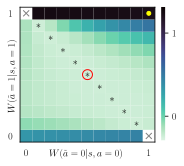

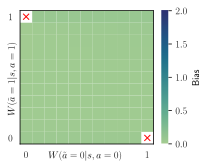

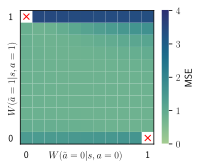

In [408]:
variances_grid = [df__.iloc[4,3] for df__ in df_out_sweepW_3a]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(variances_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

# sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax, 
#             cbar_kws={'label': 'Var', "shrink": .82}, vmin=0, vmax=4)
sns.heatmap(np.log(df_plot.T), cmap='mako_r', square=True, ax=ax,
            cbar_kws=dict(shrink=.82, aspect=40, pad=0.04), 
            vmin=-0.3, vmax=1.3,
           )
# ax.collections[0].colorbar.set_label('$\log(\mathrm{Var})$', labelpad=-9, fontsize=8)
ax.collections[0].colorbar.set_ticks([0,1])
plt.xticks([0.5,10.5], ['$0$','$1$'], rotation=0)
plt.yticks([0.5,10.5], ['$0$','$1$'])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='gray')
    if np.isclose(df_plot.loc[w0,w1], np.nanmin(df_plot.values)):
        plt.annotate('$*$', (i+0.5,j+0.5), c='k', ha='center', va='center')
        # plt.plot(i+0.5,j+0.5, marker='.', c='yellow', ms=3)
    if w0 == 0.5 and w1 == 0.5:
        plt.plot(i+0.5,j+0.5, marker='o', mfc='none', mec='r', ms=10)

plt.plot(10+0.5,10+0.5, marker='.', c='yellow', ms=8)
# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

print('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
    R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
))
plt.savefig('fig/bandit_logvar_b19_e82.pdf', bbox_inches='tight')
plt.show()
# display(df_plot)



biases_grid = [df__.iloc[4,2] for df__ in df_out_sweepW_3a]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(biases_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax, 
            cbar_kws={'label': 'Bias', "shrink": .82}, vmin=0, vmax=2)
plt.xticks([0.5,10.5], ['$0$','$1$'], rotation=0)
plt.yticks([0.5,10.5], ['$0$','$1$'])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

# plt.show()


mses_grid = [df__.iloc[4,4] for df__ in df_out_sweepW_3a]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(mses_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax, 
            cbar_kws={'label': 'MSE', "shrink": .82}, vmin=0, vmax=4)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [394]:
df_out_sweepW_3a[-1]

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.266717,0.066717,1.087341,1.089386
1,$\hat{v}(\pi_b)$,1.962717,0.762717,1.047862,1.296052
2,OIS,1.288262,0.088262,3.371571,3.372726
3,WIS,1.962717,0.762717,1.047862,1.296052
4,C-OIS,1.288262,0.088262,3.371571,3.372726
5,C-WIS,1.962717,0.762717,1.047862,1.296052


## >Same variance v2

In [401]:
R, sigma = np.array([[1, 2.],]), np.array([[1., 1.],])

In [402]:
π_b = np.array([[0.8, 0.2]])
π_e = np.array([[0.1, 0.9]])
print(π_b, π_e)

[[0.8 0.2]] [[0.1 0.9]]


In [403]:
df_out_sweepW_3b = []
for wwww, www_ in itertools.product(w_list, w_list):
    ww = np.array([[
        [wwww, 1-wwww],
        [1-www_, www_],
    ]])
    df_out = single_run(runs=2000)
    df_out_sweepW_3b.append(df_out)

<ipython-input-251-568fab191dfe>:77: RuntimeWarning: invalid value encountered in true_divide
  (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (N)
<ipython-input-251-568fab191dfe>:80: RuntimeWarning: invalid value encountered in true_divide
  (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (np.sum(w* π_e[x,a] / π_b_[x,a]) + np.sum((wc* π_e[x,1-a] / π_b_[x,1-a])[c==1])),


$R_0 \sim N(1.0,1.0^2)$, $R_1 \sim N(2.0, 1.0^2)$ 
 $\pi_b=[0.8,0.2]$, $\pi_e=[0.1,0.9]$


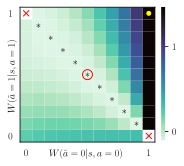

In [404]:
variances_grid = [df__.iloc[4,3] for df__ in df_out_sweepW_3b]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(variances_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

# sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax, 
#             cbar_kws={'label': 'Var', "shrink": .82}, vmin=0, vmax=4)
sns.heatmap(np.log(df_plot.T), cmap='mako_r', square=True, ax=ax,
            cbar_kws=dict(shrink=.82, aspect=40, pad=0.04), 
            # vmin=-0.3, vmax=1.3,
           )
# ax.collections[0].colorbar.set_label('$\log(\mathrm{Var})$', labelpad=-9, fontsize=8)
ax.collections[0].colorbar.set_ticks([0,1])
plt.xticks([0.5,10.5], ['$0$','$1$'], rotation=0)
plt.yticks([0.5,10.5], ['$0$','$1$'])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')
    if np.isclose(df_plot.loc[w0,w1], np.nanmin(df_plot.values)):
        plt.annotate('$*$', (i+0.5,j+0.5), c='k', ha='center', va='center')
        # plt.plot(i+0.5,j+0.5, marker='.', c='yellow', ms=3)
    if w0 == 0.5 and w1 == 0.5:
        plt.plot(i+0.5,j+0.5, marker='o', mfc='none', mec='r', ms=10)

plt.plot(10+0.5,10+0.5, marker='.', c='yellow', ms=8)
# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

print('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
    R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
))
plt.savefig('fig/bandit_logvar_b82_e19.pdf', bbox_inches='tight')
plt.show()
# display(df_plot)



# biases_grid = [df__.iloc[4,2] for df__ in df_out_sweepW_3b]

# fig, ax = plt.subplots(figsize=(3,3))
# df_plot = pd.DataFrame(np.array(biases_grid).reshape((11,11)), index=w_list, columns=w_list)
# df_plot.index.name = 'w0'
# df_plot.index = np.round(df_plot.index, 5)
# df_plot.columns.name = 'w1'
# df_plot.columns = np.round(df_plot.columns, 5)

# sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax, 
#             cbar_kws={'label': 'Bias', "shrink": .82}, vmin=0, vmax=2)
# plt.xticks([0.5,10.5], ['$0$','$1$'], rotation=0)
# plt.yticks([0.5,10.5], ['$0$','$1$'])
# ax.yaxis.set_ticks_position('none')
# ax.xaxis.set_ticks_position('none')
# plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
# plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

# for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
#     if np.isnan(df_plot.loc[w0,w1]):
#         plt.plot(i+0.5,j+0.5, marker='x', c='r')

# # plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
# #     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# # ))
# plt.gca().invert_yaxis()
# ax.spines['top'].set_visible(True)
# ax.spines['bottom'].set_visible(True)
# ax.spines['right'].set_visible(True)
# ax.spines['left'].set_visible(True)

# # plt.show()


# mses_grid = [df__.iloc[4,4] for df__ in df_out_sweepW_3b]

# fig, ax = plt.subplots(figsize=(3,3))
# df_plot = pd.DataFrame(np.array(mses_grid).reshape((11,11)), index=w_list, columns=w_list)
# df_plot.index.name = 'w0'
# df_plot.index = np.round(df_plot.index, 5)
# df_plot.columns.name = 'w1'
# df_plot.columns = np.round(df_plot.columns, 5)

# sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax, 
#             cbar_kws={'label': 'MSE', "shrink": .82}, vmin=0, vmax=4)
# plt.xticks([0.5,10.5], [0,1], rotation=0)
# plt.yticks([0.5,10.5], [0,1])
# ax.yaxis.set_ticks_position('none')
# ax.xaxis.set_ticks_position('none')
# plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
# plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

# for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
#     if np.isnan(df_plot.loc[w0,w1]):
#         plt.plot(i+0.5,j+0.5, marker='x', c='r')

# # plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
# #     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# # ))
# plt.gca().invert_yaxis()
# ax.spines['top'].set_visible(True)
# ax.spines['bottom'].set_visible(True)
# ax.spines['right'].set_visible(True)
# ax.spines['left'].set_visible(True)

# plt.show()

In [405]:
df_out_sweepW_3b[-1]

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.923013,0.023013,1.030216,1.030473
1,$\hat{v}(\pi_b)$,1.235013,-0.664987,1.078204,1.266780
2,OIS,2.027512,0.127512,4.230317,4.232238
3,WIS,1.235013,-0.664987,1.078204,1.266780
4,C-OIS,2.027512,0.127512,4.230317,4.232238
5,C-WIS,1.235013,-0.664987,1.078204,1.266780


## >>Annot has larger variance

In [49]:
R, sigma = np.array([[1, 2.],]), np.array([[1, 1],])

In [99]:
π_b = πs[3]
π_e = πs[4]
print(π_b, π_e)

[[0.1 0.9]] [[0.8 0.2]]


In [54]:
df_out_sweepW_4 = []
for wwww, www_ in itertools.product(w_list, w_list):
    ww = np.array([[
        [wwww, 1-wwww],
        [1-www_, www_],
    ]])
    df_out = single_run(annot_std_scale=2.0)
    df_out_sweepW_4.append(df_out)

<ipython-input-6-fe782cfd83b0>:77: RuntimeWarning: invalid value encountered in true_divide
  (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (N)
<ipython-input-6-fe782cfd83b0>:80: RuntimeWarning: invalid value encountered in true_divide
  (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (np.sum(w* π_e[x,a] / π_b_[x,a]) + np.sum((wc* π_e[x,1-a] / π_b_[x,1-a])[c==1])),


In [55]:
df_tmp = pd.DataFrame(index=w_list, columns=w_list)
df_tmp.index.name = 'wwww'
for (i, wwww), (j, www_) in itertools.product(enumerate(w_list), enumerate(w_list)):
    ix = i*len(w_list) + j
    df_tmp.iloc[i, j] = str(df_out_sweepW_4[ix].iloc[[2,4], [2,3,4]].round(2).values)[1:-1]
display(df_tmp.style.set_properties(**{'white-space': 'pre-wrap'}))

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
wwww,,,,,,,,,,,
0.0,[0.09 3.37 3.37] [0.09 2.24 2.25],[0.09 3.37 3.37] [0.07 1.75 1.75],[0.09 3.37 3.37] [0.06 1.66 1.66],[0.09 3.37 3.37] [0.06 1.64 1.64],[0.09 3.37 3.37] [0.06 1.63 1.63],[0.09 3.37 3.37] [0.05 1.63 1.63],[0.09 3.37 3.37] [0.05 1.63 1.63],[0.09 3.37 3.37] [0.05 1.63 1.63],[0.09 3.37 3.37] [0.05 1.63 1.63],[0.09 3.37 3.37] [0.05 1.63 1.64],[0.09 3.37 3.37] [ nan nan nan]
0.1,[0.09 3.37 3.37] [0.1 2.25 2.25],[0.09 3.37 3.37] [0.07 1.72 1.72],[0.09 3.37 3.37] [0.06 1.63 1.63],[0.09 3.37 3.37] [0.06 1.61 1.61],[0.09 3.37 3.37] [0.06 1.6 1.6 ],[0.09 3.37 3.37] [0.05 1.59 1.59],[0.09 3.37 3.37] [0.05 1.58 1.58],[0.09 3.37 3.37] [0.05 1.57 1.57],[0.09 3.37 3.37] [0.05 1.54 1.54],[0.09 3.37 3.37] [0.05 1.47 1.47],[0.09 3.37 3.37] [0.09 3.47 3.47]
0.2,[0.09 3.37 3.37] [0.1 2.25 2.25],[0.09 3.37 3.37] [0.07 1.69 1.69],[0.09 3.37 3.37] [0.06 1.61 1.61],[0.09 3.37 3.37] [0.06 1.58 1.58],[0.09 3.37 3.37] [0.06 1.57 1.57],[0.09 3.37 3.37] [0.05 1.56 1.56],[0.09 3.37 3.37] [0.05 1.54 1.54],[0.09 3.37 3.37] [0.05 1.51 1.52],[0.09 3.37 3.37] [0.05 1.47 1.47],[0.09 3.37 3.37] [0.06 1.41 1.41],[0.09 3.37 3.37] [0.09 3.46 3.46]
0.3,[0.09 3.37 3.37] [0.1 2.25 2.26],[0.09 3.37 3.37] [0.07 1.66 1.66],[0.09 3.37 3.37] [0.06 1.58 1.58],[0.09 3.37 3.37] [0.06 1.56 1.56],[0.09 3.37 3.37] [0.06 1.54 1.54],[0.09 3.37 3.37] [0.05 1.52 1.53],[0.09 3.37 3.37] [0.05 1.5 1.5 ],[0.09 3.37 3.37] [0.05 1.47 1.47],[0.09 3.37 3.37] [0.06 1.43 1.43],[0.09 3.37 3.37] [0.06 1.41 1.41],[0.09 3.37 3.37] [0.09 3.45 3.45]
0.4,[0.09 3.37 3.37] [0.1 2.26 2.26],[0.09 3.37 3.37] [0.07 1.63 1.63],[0.09 3.37 3.37] [0.06 1.56 1.56],[0.09 3.37 3.37] [0.06 1.53 1.53],[0.09 3.37 3.37] [0.06 1.52 1.52],[0.09 3.37 3.37] [0.05 1.5 1.5 ],[0.09 3.37 3.37] [0.05 1.47 1.47],[0.09 3.37 3.37] [0.06 1.44 1.44],[0.09 3.37 3.37] [0.06 1.41 1.41],[0.09 3.37 3.37] [0.06 1.45 1.45],[0.09 3.37 3.37] [0.09 3.44 3.44]
0.5,[0.09 3.37 3.37] [0.1 2.26 2.27],[0.09 3.37 3.37] [0.07 1.6 1.6 ],[0.09 3.37 3.37] [0.06 1.53 1.53],[0.09 3.37 3.37] [0.06 1.51 1.51],[0.09 3.37 3.37] [0.06 1.49 1.5 ],[0.09 3.37 3.37] [0.05 1.47 1.47],[0.09 3.37 3.37] [0.06 1.45 1.45],[0.09 3.37 3.37] [0.06 1.42 1.42],[0.09 3.37 3.37] [0.06 1.4 1.4 ],[0.09 3.37 3.37] [0.06 1.5 1.5 ],[0.09 3.37 3.37] [0.09 3.43 3.43]
0.6,[0.09 3.37 3.37] [0.1 2.27 2.27],[0.09 3.37 3.37] [0.06 1.56 1.56],[0.09 3.37 3.37] [0.06 1.51 1.51],[0.09 3.37 3.37] [0.06 1.49 1.49],[0.09 3.37 3.37] [0.05 1.47 1.47],[0.09 3.37 3.37] [0.05 1.45 1.45],[0.09 3.37 3.37] [0.06 1.43 1.43],[0.09 3.37 3.37] [0.06 1.4 1.4 ],[0.09 3.37 3.37] [0.06 1.4 1.4 ],[0.09 3.37 3.37] [0.07 1.57 1.57],[0.09 3.37 3.37] [0.09 3.42 3.42]
0.7,[0.09 3.37 3.37] [0.1 2.28 2.28],[0.09 3.37 3.37] [0.06 1.53 1.53],[0.09 3.37 3.37] [0.06 1.49 1.49],[0.09 3.37 3.37] [0.05 1.47 1.47],[0.09 3.37 3.37] [0.05 1.46 1.46],[0.09 3.37 3.37] [0.05 1.43 1.44],[0.09 3.37 3.37] [0.06 1.41 1.41],[0.09 3.37 3.37] [0.06 1.39 1.39],[0.09 3.37 3.37] [0.06 1.41 1.41],[0.09 3.37 3.37] [0.07 1.63 1.63],[0.09 3.37 3.37] [0.09 3.41 3.41]
0.8,[0.09 3.37 3.37] [0.1 2.28 2.29],[0.09 3.37 3.37] [0.06 1.5 1.5 ],[0.09 3.37 3.37] [0.05 1.47 1.47],[0.09 3.37 3.37] [0.05 1.46 1.46],[0.09 3.37 3.37] [0.05 1.44 1.44],[0.09 3.37 3.37] [0.05 1.42 1.42],[0.09 3.37 3.37] [0.06 1.4 1.4 ],[0.09 3.37 3.37] [0.06 1.39 1.39],[0.09 3.37 3.37] [0.06 1.42 1.42],[0.09 3.37 3.37] [0.07 1.69 1.7 ],[0.09 3.37 3.37] [0.09 3.39 3.4 ]


$R_0 \sim N(1.0,1.0^2)$, $R_1 \sim N(2.0, 1.0^2)$ 
 $\pi_b=[0.8,0.2]$, $\pi_e=[0.1,0.9]$


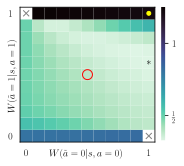

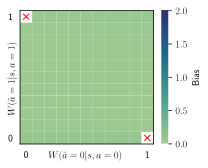

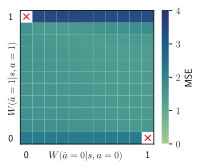

In [409]:
variances_grid = [df__.iloc[4,3] for df__ in df_out_sweepW_4]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(variances_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

# sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax,
#             cbar_kws={'label': 'Var', "shrink": .82}, 
#             vmin=0, vmax=4)
sns.heatmap(np.log(df_plot.T), cmap='mako_r', square=True, ax=ax,
            cbar_kws=dict(shrink=.82, aspect=40, pad=0.04), 
            # vmin=-0.3, vmax=1.3,
           )
# ax.collections[0].colorbar.set_label('$\log(\mathrm{Var})$', labelpad=-9, fontsize=8)
ax.collections[0].colorbar.set_ticks([0.5,1])
ax.collections[0].colorbar.set_ticklabels([r'$\frac{1}{2}$', '$1$'])
plt.xticks([0.5,10.5], ['$0$','$1$'], rotation=0)
plt.yticks([0.5,10.5], ['$0$','$1$'])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='gray')
    if np.isclose(df_plot.loc[w0,w1], np.nanmin(df_plot.values)):
        plt.annotate('$*$', (i+0.5,j+0.5), c='k', ha='center', va='center')
        # plt.plot(i+0.5,j+0.5, marker='.', c='yellow', ms=3)
    if w0 == 0.5 and w1 == 0.5:
        plt.plot(i+0.5,j+0.5, marker='o', mfc='none', mec='r', ms=10)

plt.plot(10+0.5,10+0.5, marker='.', c='yellow', ms=8)
# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

print('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
    R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
))
plt.savefig('fig/bandit_logvar_b19_e82_annotlargevar.pdf', bbox_inches='tight')
plt.show()
# display(df_plot)


biases_grid = [df__.iloc[4,2] for df__ in df_out_sweepW_4]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(biases_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='crest', square=True, cbar_kws={'label': 'Bias', "shrink": .82}, vmin=0, vmax=2, ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()


mses_grid = [df__.iloc[4,4] for df__ in df_out_sweepW_4]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(mses_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='crest', square=True, cbar_kws={'label': 'MSE', "shrink": .82}, vmin=0, vmax=4, ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

## >>Annot has smaller variance

In [84]:
R, sigma = np.array([[1, 2.],]), np.array([[1, 1],])

In [101]:
π_b = πs[3]
π_e = πs[4]
print(π_b, π_e)

[[0.1 0.9]] [[0.8 0.2]]


In [86]:
df_out_sweepW_6 = []
for wwww, www_ in itertools.product(w_list, w_list):
    ww = np.array([[
        [wwww, 1-wwww],
        [1-www_, www_],
    ]])
    df_out = single_run(annot_std_scale=0.5)
    df_out_sweepW_6.append(df_out)

<ipython-input-6-fe782cfd83b0>:77: RuntimeWarning: invalid value encountered in true_divide
  (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (N)
<ipython-input-6-fe782cfd83b0>:80: RuntimeWarning: invalid value encountered in true_divide
  (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (np.sum(w* π_e[x,a] / π_b_[x,a]) + np.sum((wc* π_e[x,1-a] / π_b_[x,1-a])[c==1])),


In [87]:
df_tmp = pd.DataFrame(index=w_list, columns=w_list)
df_tmp.index.name = 'wwww'
for (i, wwww), (j, www_) in itertools.product(enumerate(w_list), enumerate(w_list)):
    ix = i*len(w_list) + j
    df_tmp.iloc[i, j] = str(df_out_sweepW_6[ix].iloc[[2,4], [2,3,4]].round(2).values)[1:-1]
display(df_tmp.style.set_properties(**{'white-space': 'pre-wrap'}))

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
wwww,,,,,,,,,,,
0.0,[0.09 3.37 3.37] [0.04 1.1 1.1 ],[0.09 3.37 3.37] [0.03 0.54 0.54],[0.09 3.37 3.37] [0.02 0.44 0.44],[0.09 3.37 3.37] [0.02 0.44 0.44],[0.09 3.37 3.37] [0.02 0.45 0.45],[0.09 3.37 3.37] [0.02 0.47 0.47],[0.09 3.37 3.37] [0.02 0.48 0.48],[0.09 3.37 3.37] [0.02 0.5 0.5 ],[0.09 3.37 3.37] [0.02 0.51 0.51],[0.09 3.37 3.37] [0.02 0.52 0.52],[0.09 3.37 3.37] [ nan nan nan]
0.1,[0.09 3.37 3.37] [0.04 1.13 1.13],[0.09 3.37 3.37] [0.03 0.54 0.54],[0.09 3.37 3.37] [0.02 0.44 0.44],[0.09 3.37 3.37] [0.02 0.43 0.43],[0.09 3.37 3.37] [0.02 0.44 0.44],[0.09 3.37 3.37] [0.02 0.45 0.45],[0.09 3.37 3.37] [0.02 0.46 0.46],[0.09 3.37 3.37] [0.02 0.46 0.46],[0.09 3.37 3.37] [0.02 0.46 0.46],[0.09 3.37 3.37] [0.03 0.47 0.47],[0.09 3.37 3.37] [0.09 3.46 3.46]
0.2,[0.09 3.37 3.37] [0.04 1.15 1.15],[0.09 3.37 3.37] [0.03 0.53 0.53],[0.09 3.37 3.37] [0.02 0.44 0.44],[0.09 3.37 3.37] [0.02 0.43 0.43],[0.09 3.37 3.37] [0.02 0.44 0.44],[0.09 3.37 3.37] [0.02 0.45 0.45],[0.09 3.37 3.37] [0.02 0.45 0.45],[0.09 3.37 3.37] [0.02 0.45 0.45],[0.09 3.37 3.37] [0.03 0.47 0.47],[0.09 3.37 3.37] [0.03 0.61 0.62],[0.09 3.37 3.37] [0.09 3.45 3.45]
0.3,[0.09 3.37 3.37] [0.04 1.18 1.18],[0.09 3.37 3.37] [0.03 0.52 0.52],[0.09 3.37 3.37] [0.03 0.44 0.44],[0.09 3.37 3.37] [0.02 0.44 0.44],[0.09 3.37 3.37] [0.02 0.44 0.44],[0.09 3.37 3.37] [0.02 0.45 0.45],[0.09 3.37 3.37] [0.02 0.46 0.46],[0.09 3.37 3.37] [0.03 0.47 0.47],[0.09 3.37 3.37] [0.03 0.53 0.53],[0.09 3.37 3.37] [0.04 0.8 0.8 ],[0.09 3.37 3.37] [0.09 3.44 3.44]
0.4,[0.09 3.37 3.37] [0.04 1.21 1.21],[0.09 3.37 3.37] [0.03 0.51 0.51],[0.09 3.37 3.37] [0.03 0.44 0.44],[0.09 3.37 3.37] [0.02 0.44 0.44],[0.09 3.37 3.37] [0.02 0.45 0.45],[0.09 3.37 3.37] [0.02 0.46 0.46],[0.09 3.37 3.37] [0.03 0.47 0.47],[0.09 3.37 3.37] [0.03 0.51 0.51],[0.09 3.37 3.37] [0.03 0.61 0.61],[0.09 3.37 3.37] [0.04 0.97 0.97],[0.09 3.37 3.37] [0.09 3.43 3.44]
0.5,[0.09 3.37 3.37] [0.04 1.23 1.23],[0.09 3.37 3.37] [0.03 0.5 0.5 ],[0.09 3.37 3.37] [0.03 0.45 0.45],[0.09 3.37 3.37] [0.02 0.45 0.45],[0.09 3.37 3.37] [0.02 0.46 0.46],[0.09 3.37 3.37] [0.03 0.47 0.47],[0.09 3.37 3.37] [0.03 0.5 0.5 ],[0.09 3.37 3.37] [0.03 0.55 0.55],[0.09 3.37 3.37] [0.03 0.69 0.7 ],[0.09 3.37 3.37] [0.04 1.12 1.13],[0.09 3.37 3.37] [0.09 3.42 3.43]
0.6,[0.09 3.37 3.37] [0.04 1.26 1.26],[0.09 3.37 3.37] [0.03 0.49 0.49],[0.09 3.37 3.37] [0.03 0.45 0.45],[0.09 3.37 3.37] [0.03 0.46 0.46],[0.09 3.37 3.37] [0.03 0.47 0.47],[0.09 3.37 3.37] [0.03 0.49 0.49],[0.09 3.37 3.37] [0.03 0.53 0.53],[0.09 3.37 3.37] [0.03 0.6 0.6 ],[0.09 3.37 3.37] [0.04 0.78 0.78],[0.09 3.37 3.37] [0.05 1.26 1.26],[0.09 3.37 3.37] [0.09 3.41 3.42]
0.7,[0.09 3.37 3.37] [0.04 1.29 1.29],[0.09 3.37 3.37] [0.03 0.48 0.48],[0.09 3.37 3.37] [0.03 0.46 0.46],[0.09 3.37 3.37] [0.03 0.47 0.47],[0.09 3.37 3.37] [0.03 0.49 0.49],[0.09 3.37 3.37] [0.03 0.51 0.51],[0.09 3.37 3.37] [0.03 0.56 0.56],[0.09 3.37 3.37] [0.03 0.65 0.66],[0.09 3.37 3.37] [0.04 0.86 0.86],[0.09 3.37 3.37] [0.05 1.38 1.38],[0.09 3.37 3.37] [0.09 3.4 3.4 ]
0.8,[0.09 3.37 3.37] [0.04 1.31 1.31],[0.09 3.37 3.37] [0.03 0.47 0.47],[0.09 3.37 3.37] [0.03 0.47 0.47],[0.09 3.37 3.37] [0.03 0.49 0.49],[0.09 3.37 3.37] [0.03 0.51 0.51],[0.09 3.37 3.37] [0.03 0.54 0.54],[0.09 3.37 3.37] [0.03 0.59 0.6 ],[0.09 3.37 3.37] [0.03 0.71 0.71],[0.09 3.37 3.37] [0.04 0.94 0.94],[0.09 3.37 3.37] [0.05 1.49 1.49],[0.09 3.37 3.37] [0.09 3.39 3.39]


$R_0 \sim N(1.0,1.0^2)$, $R_1 \sim N(2.0, 1.0^2)$ 
 $\pi_b=[0.8,0.2]$, $\pi_e=[0.1,0.9]$


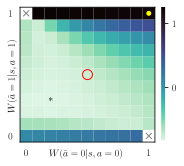

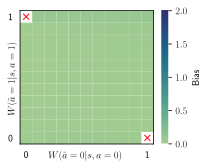

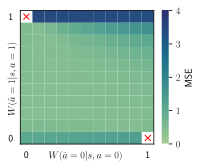

In [410]:
variances_grid = [df__.iloc[4,3] for df__ in df_out_sweepW_6]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(variances_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(np.log(df_plot.T), cmap='mako_r', square=True, ax=ax,
            cbar_kws=dict(shrink=.82, aspect=40, pad=0.04), 
            # vmin=-1, vmax=1,
           )
# ax.collections[0].colorbar.set_label('$\log(\mathrm{Var})$', labelpad=-9, fontsize=8, ha='left')
ax.collections[0].colorbar.set_ticks([0,1])
# ax.collections[0].colorbar.set_ticklabels([r'$\frac{1}{2}$', '$1$'])
plt.xticks([0.5,10.5], ['$0$','$1$'], rotation=0)
plt.yticks([0.5,10.5], ['$0$','$1$'])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='gray')
    if np.isclose(df_plot.loc[w0,w1], np.nanmin(df_plot.values)):
        plt.annotate('$*$', (i+0.5,j+0.5), c='k', ha='center', va='center')
        # plt.plot(i+0.5,j+0.5, marker='.', c='yellow', ms=3)
    if w0 == 0.5 and w1 == 0.5:
        plt.plot(i+0.5,j+0.5, marker='o', mfc='none', mec='r', ms=10)

plt.plot(10+0.5,10+0.5, marker='.', c='yellow', ms=8)
# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

print('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
    R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
))
plt.savefig('fig/bandit_logvar_b19_e82_annotsmallvar.pdf', bbox_inches='tight')
plt.show()
# display(df_plot)


biases_grid = [df__.iloc[4,2] for df__ in df_out_sweepW_6]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(biases_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='crest', square=True, cbar_kws={'label': 'Bias', "shrink": .82}, vmin=0, vmax=2, ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.show()


mses_grid = [df__.iloc[4,4] for df__ in df_out_sweepW_6]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(mses_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='crest', square=True, cbar_kws={'label': 'MSE', "shrink": .82}, vmin=0, vmax=4, ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

## >>Annot not useful

In [128]:
R, sigma = np.array([[1, 2.],]), np.array([[1, 1],])

In [129]:
π_b = np.array([[0.9, 0.1]])
π_e = np.array([[0.95, 0.05]])
print(π_b, π_e)

[[0.9 0.1]] [[0.95 0.05]]


In [130]:
df_out_sweepW_7 = []
for wwww, www_ in itertools.product(w_list, w_list):
    ww = np.array([[
        [wwww, 1-wwww],
        [1-www_, www_],
    ]])
    df_out = single_run()
    df_out_sweepW_7.append(df_out)

<ipython-input-6-fe782cfd83b0>:77: RuntimeWarning: invalid value encountered in true_divide
  (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (N)
<ipython-input-6-fe782cfd83b0>:80: RuntimeWarning: invalid value encountered in true_divide
  (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (np.sum(w* π_e[x,a] / π_b_[x,a]) + np.sum((wc* π_e[x,1-a] / π_b_[x,1-a])[c==1])),


In [131]:
df_tmp = pd.DataFrame(index=w_list, columns=w_list)
df_tmp.index.name = 'wwww'
for (i, wwww), (j, www_) in itertools.product(enumerate(w_list), enumerate(w_list)):
    ix = i*len(w_list) + j
    df_tmp.iloc[i, j] = str(df_out_sweepW_7[ix].iloc[[2,4], [2,3,4]].round(2).values)[1:-1]
display(df_tmp.style.set_properties(**{'white-space': 'pre-wrap'}))

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
wwww,,,,,,,,,,,
0.0,[ 0.07 1.02 1.02] [-0.06 3.59 3.59],[ 0.07 1.02 1.02] [-0.06 3.59 3.59],[ 0.07 1.02 1.02] [-0.06 3.59 3.59],[ 0.07 1.02 1.02] [-0.06 3.6 3.6 ],[ 0.07 1.02 1.02] [-0.06 3.6 3.6 ],[ 0.07 1.02 1.02] [-0.06 3.6 3.6 ],[ 0.07 1.02 1.02] [-0.06 3.61 3.61],[ 0.07 1.02 1.02] [-0.06 3.61 3.61],[ 0.07 1.02 1.02] [-0.06 3.61 3.61],[ 0.07 1.02 1.02] [-0.06 3.61 3.61],[0.07 1.02 1.02] [ nan nan nan]
0.1,[0.07 1.02 1.02] [0. 1.83 1.83],[0.07 1.02 1.02] [0.01 1.74 1.74],[0.07 1.02 1.02] [0.01 1.64 1.64],[0.07 1.02 1.02] [0.01 1.54 1.54],[0.07 1.02 1.02] [0.02 1.42 1.42],[0.07 1.02 1.02] [0.02 1.3 1.3 ],[0.07 1.02 1.02] [0.03 1.17 1.17],[0.07 1.02 1.02] [0.04 1.05 1.05],[0.07 1.02 1.02] [0.05 0.95 0.95],[0.07 1.02 1.02] [0.06 0.93 0.94],[0.07 1.02 1.02] [0.07 1.05 1.06]
0.2,[0.07 1.02 1.02] [0.03 1.29 1.29],[0.07 1.02 1.02] [0.03 1.23 1.23],[0.07 1.02 1.02] [0.03 1.16 1.17],[0.07 1.02 1.02] [0.04 1.1 1.1 ],[0.07 1.02 1.02] [0.04 1.05 1.05],[0.07 1.02 1.02] [0.04 0.99 0.99],[0.07 1.02 1.02] [0.05 0.95 0.95],[0.07 1.02 1.02] [0.05 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.94],[0.07 1.02 1.02] [0.06 0.97 0.97],[0.07 1.02 1.02] [0.07 1.05 1.06]
0.3,[0.07 1.02 1.02] [0.04 1.08 1.08],[0.07 1.02 1.02] [0.04 1.04 1.04],[0.07 1.02 1.02] [0.04 1.01 1.01],[0.07 1.02 1.02] [0.04 0.98 0.98],[0.07 1.02 1.02] [0.05 0.95 0.95],[0.07 1.02 1.02] [0.05 0.93 0.94],[0.07 1.02 1.02] [0.05 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.94],[0.07 1.02 1.02] [0.06 0.95 0.96],[0.07 1.02 1.02] [0.07 0.99 1. ],[0.07 1.02 1.02] [0.07 1.05 1.05]
0.4,[0.07 1.02 1.02] [0.04 0.99 0.99],[0.07 1.02 1.02] [0.05 0.97 0.97],[0.07 1.02 1.02] [0.05 0.95 0.95],[0.07 1.02 1.02] [0.05 0.94 0.94],[0.07 1.02 1.02] [0.05 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.94],[0.07 1.02 1.02] [0.06 0.95 0.95],[0.07 1.02 1.02] [0.06 0.97 0.97],[0.07 1.02 1.02] [0.07 1.01 1.01],[0.07 1.02 1.02] [0.07 1.05 1.05]
0.5,[0.07 1.02 1.02] [0.05 0.95 0.95],[0.07 1.02 1.02] [0.05 0.94 0.94],[0.07 1.02 1.02] [0.05 0.93 0.93],[0.07 1.02 1.02] [0.05 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.94],[0.07 1.02 1.02] [0.06 0.94 0.95],[0.07 1.02 1.02] [0.06 0.96 0.96],[0.07 1.02 1.02] [0.07 0.98 0.99],[0.07 1.02 1.02] [0.07 1.01 1.01],[0.07 1.02 1.02] [0.07 1.05 1.05]
0.6,[0.07 1.02 1.02] [0.05 0.93 0.93],[0.07 1.02 1.02] [0.05 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.94],[0.07 1.02 1.02] [0.06 0.94 0.94],[0.07 1.02 1.02] [0.06 0.95 0.96],[0.07 1.02 1.02] [0.06 0.97 0.97],[0.07 1.02 1.02] [0.07 0.99 0.99],[0.07 1.02 1.02] [0.07 1.01 1.02],[0.07 1.02 1.02] [0.07 1.04 1.05]
0.7,[0.07 1.02 1.02] [0.05 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.94],[0.07 1.02 1.02] [0.06 0.94 0.94],[0.07 1.02 1.02] [0.06 0.95 0.95],[0.07 1.02 1.02] [0.06 0.96 0.96],[0.07 1.02 1.02] [0.07 0.98 0.98],[0.07 1.02 1.02] [0.07 0.99 1. ],[0.07 1.02 1.02] [0.07 1.02 1.02],[0.07 1.02 1.02] [0.07 1.04 1.04]
0.8,[0.07 1.02 1.02] [0.06 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.93],[0.07 1.02 1.02] [0.06 0.93 0.94],[0.07 1.02 1.02] [0.06 0.94 0.94],[0.07 1.02 1.02] [0.06 0.95 0.95],[0.07 1.02 1.02] [0.06 0.96 0.96],[0.07 1.02 1.02] [0.06 0.97 0.97],[0.07 1.02 1.02] [0.07 0.98 0.98],[0.07 1.02 1.02] [0.07 1. 1. ],[0.07 1.02 1.02] [0.07 1.01 1.02],[0.07 1.02 1.02] [0.07 1.03 1.04]


$R_0 \sim N(1.0,1.0^2)$, $R_1 \sim N(2.0, 1.0^2)$ 
 $\pi_b=[0.8,0.2]$, $\pi_e=[0.1,0.9]$


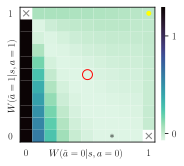

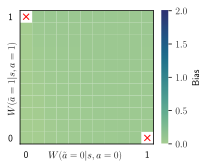

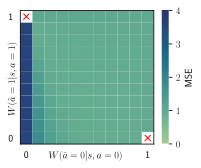

In [411]:
variances_grid = [df__.iloc[4,3] for df__ in df_out_sweepW_7]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(variances_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

# sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax,
#             cbar_kws={'label': 'Var', "shrink": .82}, vmin=0, vmax=4)
sns.heatmap(np.log(df_plot.T), cmap='mako_r', square=True, ax=ax,
            cbar_kws=dict(shrink=.82, aspect=40, pad=0.04), 
            # vmin=-0.3, vmax=1.3,
           )
# ax.collections[0].colorbar.set_label('$\log(\mathrm{Var})$', labelpad=-9, fontsize=8)
ax.collections[0].colorbar.set_ticks([0,1])
plt.xticks([0.5,10.5], ['$0$','$1$'], rotation=0)
plt.yticks([0.5,10.5], ['$0$','$1$'])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)


for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='gray')
    if np.isclose(df_plot.loc[w0,w1], np.nanmin(df_plot.values)):
        plt.annotate('$*$', (i+0.5,j+0.5), c='k', ha='center', va='center')
    if w0 == 0.5 and w1 == 0.5:
        plt.plot(i+0.5,j+0.5, marker='o', mfc='none', mec='r', ms=10)

plt.plot(10+0.5,10+0.5, marker='.', c='yellow', ms=8)
# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

print('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
    R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
))
plt.savefig('fig/bandit_logvar_b91_e9505.pdf', bbox_inches='tight')
plt.show()
# display(df_plot)


biases_grid = [df__.iloc[4,2] for df__ in df_out_sweepW_7]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(biases_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='crest', square=True, cbar_kws={'label': 'Bias', "shrink": .82}, vmin=0, vmax=2, ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()


mses_grid = [df__.iloc[4,4] for df__ in df_out_sweepW_7]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(mses_grid).reshape((11,11)), index=w_list, columns=w_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='crest', square=True, cbar_kws={'label': 'MSE', "shrink": .82}, vmin=0, vmax=4, ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(w_list), enumerate(w_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

# Ideal counterfactual annotations, non-constant weights mean split

In [ ]:
def single_run_Wrange(W_ranges, runs=1000, annot_std_scale=1.0):
    np.random.seed(42)

    # True value of π_e
    Js = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_e[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        J = np.sum(r) / N
        Js.append(J)

    # Standard IS
    Gs = []
    OISs = []
    WISs = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        G = np.sum(r) / N
        Gs.append(G)

        if use_πD:
            π_b_ = np.array([
                [(np.sum((x==0)&(a==0)))/np.sum(x==0), 
                 (np.sum((x==0)&(a==1)))/np.sum(x==0)],
            ])
        else:
            π_b_ = π_b

        rho = π_e[x,a] / π_b_[x,a]
        OISs.append(np.sum(rho * r) / N)
        WISs.append(np.sum(rho * r) / np.sum(rho))


    # Collect data using π_b - combining counterfactuals with factuals
    FC_OISs_w = []
    FC_WISs_w = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        rng_c = np.random.default_rng(seed=100000+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        rho = π_e[x,a] / π_b[x,a]

        # counterfactual flag
        c = np.array([rng_c.choice(2, p=[1-Pc[xi,ai], Pc[xi,ai]]) for xi,ai in zip(x,a)])

        # counterfactual reward
        rc = np.array([rng_c.normal(R[xi,1-ai], annot_std_scale*sigma[xi,1-ai]) for xi,ai in zip(x,a)])
        rc[c==0] = np.nan

        # trajectory-wise weight
#         w = np.ones(N)
#         w[c==1] = ww[x[c==1], a[c==1], a[c==1]]
#         wc = np.zeros(N)
#         wc[c==1] = ww[x[c==1], a[c==1], 1-a[c==1]]
        
        w = np.ones(N)
        w[c==1] = np.random.uniform(ww_mean[x[c==1], a[c==1], a[c==1]] - W_ranges[x[c==1], a[c==1]]/2, 
                                    ww_mean[x[c==1], a[c==1], a[c==1]] + W_ranges[x[c==1], a[c==1]]/2)
        # w[c==1] = w[c==1]/np.mean(w[c==1])*ww_mean[x[c==1], a[c==1], a[c==1]]  ### renormalize such that mean factual weight is exactly ww_mean
        wc = np.zeros(N)
        wc[c==1] = 1 - w[c==1] #1 - ww[x[c==1], a[c==1]]
        
        if use_πD:
            # augmented behavior policy
            π_b_ = np.array([
                [(np.sum(w*((x==0)&(a==0)))+np.sum(wc*((x==0)&(a==1)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1)))), 
                 (np.sum(w*((x==0)&(a==1)))+np.sum(wc*((x==0)&(a==0)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1))))],
            ])
        else:
            # augmented behavior policy
            π_b_ = np.array([
                [π_b[0,0]*ww_mean[0,0,0]+π_b[0,1]*ww_mean[0,1,0], π_b[0,0]*ww_mean[0,0,1]+π_b[0,1]*ww_mean[0,1,1]],
            ])
            π_b_ = π_b_ / π_b_.sum(axis=1, keepdims=True)

        FC_OISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (N)
        )
        FC_WISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (np.sum(w* π_e[x,a] / π_b_[x,a]) + np.sum((wc* π_e[x,1-a] / π_b_[x,1-a])[c==1])),
        )

    df_bias_var = []
    for name, values in [
        ('$\hat{v}(\pi_e)$', Js),
        ('$\hat{v}(\pi_b)$', Gs),
        ('OIS', OISs),
        ('WIS', WISs),
        ('C-OIS', FC_OISs_w),
        ('C-WIS', FC_WISs_w),
    ]:
        df_bias_var.append([name, 
                            np.mean(values), 
                            np.mean(values - d0@np.sum(π_e*R, axis=1)), 
                            np.sqrt(np.var(values)), 
                            np.sqrt(np.mean(np.square(values - d0@np.sum(π_e*R, axis=1))))])
    return pd.DataFrame(df_bias_var, columns=['Approach', 'Mean', 'Bias', 'Std', 'RMSE'])

In [192]:
## probability of getting a counterfactual annotation
Pc = np.array([
    [1., 1.],
])

In [290]:
# Unf dist, mean 0.5, range sweep from 0 to 1
ww_mean = np.array([[
    [0.5, 0.5],
    [0.5, 0.5],
]])
ww_range_list = list(np.arange(0,1+1e-10,0.1).round(2))
ww_range_list

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

## >>Policy combination 1

In [291]:
π_b = np.array([[0.8, 0.2]])
π_e = np.array([[0.1, 0.9]])
print(π_b, π_e)

[[0.8 0.2]] [[0.1 0.9]]


In [292]:
df_out_sweepWrange = []
for w0_range, w1_range in itertools.product(ww_range_list, ww_range_list):
    df_out = single_run_Wrange(np.array([[w0_range, w1_range]]))
    df_out_sweepWrange.append(df_out)

$R_0 \sim N(1.0,1^2)$, $R_1 \sim N(2.0, 1^2)$ 
 $\pi_b=[0.8,0.2]$, $\pi_e=[0.1,0.9]$


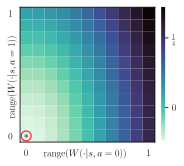

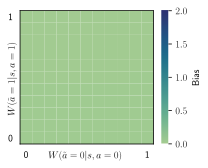

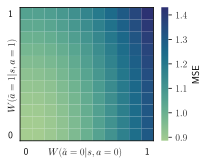

In [352]:
variances_grid = [df__.iloc[4,3] for df__ in df_out_sweepWrange]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(variances_grid).reshape((11,11)), index=ww_range_list, columns=ww_range_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

# sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax,
#             cbar_kws={'label': 'Var', "shrink": .82}, vmin=0, vmax=4)
sns.heatmap(np.log(df_plot.T), cmap='mako_r', square=True, ax=ax,
            cbar_kws=dict(shrink=.82, aspect=40, pad=0.04), 
            # vmin=-0.3, vmax=1.3,
           )
# ax.collections[0].colorbar.set_label('$\log(\mathrm{Var})$', labelpad=-9, fontsize=8)
ax.collections[0].colorbar.set_ticks([0, 0.25])
ax.collections[0].colorbar.set_ticklabels(['$0$', r'$\frac{1}{4}$'])
plt.xticks([0.5,10.5], ['$0$','$1$'], rotation=0)
plt.yticks([0.5,10.5], ['$0$','$1$'])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$\\mathrm{range}(W(\\cdot|s,a=0))$', labelpad=-9)
plt.ylabel('$\\mathrm{range}(W(\\cdot|s,a=1))$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(ww_range_list), enumerate(ww_range_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='gray')
    if np.isclose(df_plot.loc[w0,w1], np.nanmin(df_plot.values)):
        plt.annotate('$*$', (i+0.5,j+0.5), c='k', ha='center', va='center')
    if w0 == 0. and w1 == 0.:
        plt.plot(i+0.5,j+0.5, marker='o', mfc='none', mec='r', ms=10)

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

print('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
    R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
))
plt.savefig('fig/bandit_logvar_b82_e19_wrange.pdf', bbox_inches='tight')
plt.show()
# display(df_plot)


biases_grid = [df__.iloc[4,2] for df__ in df_out_sweepWrange]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(biases_grid).reshape((11,11)), index=ww_range_list, columns=ww_range_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='crest', square=True, cbar_kws={'label': 'Bias', "shrink": .82}, vmin=0, vmax=2, ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(ww_range_list), enumerate(ww_range_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()


mses_grid = [df__.iloc[4,4] for df__ in df_out_sweepWrange]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(mses_grid).reshape((11,11)), index=ww_range_list, columns=ww_range_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='crest', square=True, cbar_kws={'label': 'MSE', "shrink": .82}, 
            # vmin=0, vmax=4, 
            ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(ww_range_list), enumerate(ww_range_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()